In [1]:
import kerastuner as kt
from tensorflow import keras

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from kerastuner_tensorboard_logger import TensorBoardLogger, setup_tb

%load_ext tensorboard

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
BASIC_PATH = "/dataset/"

In [4]:
## 만약에 위에 clean code 지나치고 싶으면
CLEAN_TRAIN_X = "final/X_train.npy"
CLEAN_TRAIN_Y = "final/y_train.npy"

CLEAN_TEST_X = "final/X_test.npy"
CLEAN_TEST_Y = "final/y_test.npy"

X_train = np.load(BASIC_PATH+CLEAN_TRAIN_X)
y_train = np.load(BASIC_PATH+CLEAN_TRAIN_Y)

X_test = np.load(BASIC_PATH+CLEAN_TEST_X)
y_test = np.load(BASIC_PATH+CLEAN_TEST_Y)

In [5]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(148572, 50)
(148572,)
(49575, 50)
(49575,)


### * 기본 정보

vocab_size = 20744<br>
max_len = 50<br>
word_dim = 100

batch_size = 64

optimizer = RMSProp

In [6]:
vocab_size = 20744
max_len = 50
word_vector_dim = 100

batch_size = 64

epochs = 20

## [1] train data split 진행

In [7]:
from sklearn.model_selection import train_test_split # 데이터 셋 분할

TEST_SPLIT = 0.2
RANDOM_SEED = 100

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=TEST_SPLIT, random_state=RANDOM_SEED)

In [8]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(118857, 50)
(118857,)
(29715, 50)
(29715,)
(49575, 50)
(49575,)


## [2] Modeling

### result

1. LSTM : 86.1%
2. CNN : 86.5%
3. BiLSTM : 85.8%
4. GRU : 84.5%
5. CNN-LSTM : 86.3%

In [9]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, Bidirectional, GRU
from tensorflow.keras.layers import BatchNormalization, GlobalMaxPooling1D, MaxPooling1D, AveragePooling1D

from tensorflow.keras.layers import Dropout, Input, Flatten, Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [10]:
def show_plot(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

### [2-1] LSTM

In [87]:
lstm = Sequential()
lstm.add(Embedding(vocab_size, word_vector_dim))
lstm.add(LSTM(128))
lstm.add(Dense(1, activation='sigmoid'))

In [88]:
es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc1 = ModelCheckpoint(BASIC_PATH + 'final/LSTM_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
lstm.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [89]:
history_lstm = lstm.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=2,
                    callbacks = [es1, mc1])

Train on 118857 samples, validate on 29715 samples
Epoch 1/20
118857/118857 - 34s - loss: 0.3863 - accuracy: 0.8252 - val_loss: 0.3397 - val_accuracy: 0.8532
Epoch 2/20
118857/118857 - 32s - loss: 0.3183 - accuracy: 0.8635 - val_loss: 0.3305 - val_accuracy: 0.8579
Epoch 3/20
118857/118857 - 32s - loss: 0.2923 - accuracy: 0.8770 - val_loss: 0.3218 - val_accuracy: 0.8630
Epoch 4/20
118857/118857 - 32s - loss: 0.2719 - accuracy: 0.8872 - val_loss: 0.3251 - val_accuracy: 0.8669
Epoch 5/20
118857/118857 - 32s - loss: 0.2555 - accuracy: 0.8954 - val_loss: 0.3423 - val_accuracy: 0.8514
Epoch 6/20
118857/118857 - 32s - loss: 0.2396 - accuracy: 0.9043 - val_loss: 0.3257 - val_accuracy: 0.8675
Epoch 00006: early stopping


49575/49575 - 5s - loss: 0.3303 - accuracy: 0.8630
LSTM Accuracy result :  [0.330333984198741, 0.86301565]


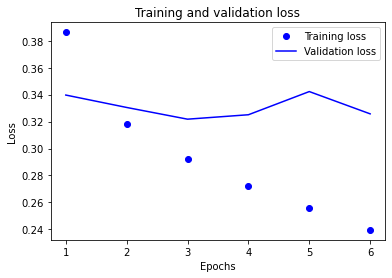

In [90]:
print("LSTM Accuracy result : ", lstm.evaluate(X_test, y_test, verbose=2))

show_plot(history_lstm.history)

In [91]:
## 모델 저장
lstm.save(BASIC_PATH + 'final/LSTM_model.h5')

### [5-2] CNN

#### hyper parameter tuning

In [11]:
def model_build_cnn(hp):
    inputs = Input(shape=(max_len, ))
    x = Embedding(vocab_size, word_vector_dim, input_length = max_len)(inputs)
    x = Dropout(hp.Float('dropout1', 0, 0.5, step=0.1, default = 0.5))(x)
    
    conv_block = []
    for i in range(hp.Int('conv_blocks', 1, 4, default=3)):
        # filter hypter
        filters = hp.Choice('filters_' + str(i), [32, 64, 128, 256, 512])
        kernel_size = hp.Int('kernel_size_'+str(i), 3, 5, step=1)
        
        conv = Conv1D(filters = filters,kernel_size = kernel_size,activation = "relu",padding = "valid",strides = 1)(x)
        
        if hp.Choice('pooling_'+str(i), ['max', 'global']) == 'max':
            conv = MaxPooling1D()(conv)
        else:
            conv = GlobalMaxPooling1D()(conv)
            
        conv = Flatten()(conv)
        conv_block.append(conv)
    
    x = Concatenate()(conv_block) if len(conv_block) > 1 else conv_block[0]
    
    x = Dropout(hp.Float('dropout2', 0, 0.5, step=0.1, default = 0.5))(x)
    x = Dense(hp.Choice('hidden_size', [32, 64, 128, 256, 512]), activation='relu')(x)
    
    outputs = Dense(1, activation="sigmoid")(x)
    
    cnn = Model(inputs, outputs)
    
    lr = hp.Float('learning_rate', 1e-4, 1e-1, sampling='log', default=1e-3)
    
    if hp.Choice('optimizer_', ['adam', 'rmsprop']) == 'rmsprop':
        cnn.compile(
            optimizer=tf.keras.optimizers.RMSprop(lr), 
            loss='binary_crossentropy', 
            metrics=['accuracy'])
    else:
        cnn.compile(
            optimizer=tf.keras.optimizers.Adam(lr), 
            loss='binary_crossentropy', 
            metrics=['accuracy'])
    
    return cnn

In [12]:
tuner = kt.Hyperband(
    model_build_cnn, objective="val_accuracy", max_epochs=20, executions_per_trial=5, 
    directory="logs/tuner", project_name="tf_test", 
    logger=TensorBoardLogger(
        metrics=["val_accuracy"], logdir="logs/hparams"
    ),
)

In [13]:
setup_tb(tuner)

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
tuner.search(X_train, y_train, epochs = epochs, batch_size=batch_size,
             validation_data = (X_val, y_val), callbacks=[callback], verbose=2)

Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 48s - loss: 0.4677 - accuracy: 0.7599 - val_loss: 0.3670 - val_accuracy: 0.8409
Epoch 2/3
118857/118857 - 45s - loss: 0.3520 - accuracy: 0.8470 - val_loss: 0.3457 - val_accuracy: 0.8513
Epoch 3/3
118857/118857 - 46s - loss: 0.3194 - accuracy: 0.8637 - val_loss: 0.3360 - val_accuracy: 0.8558
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 46s - loss: 0.4658 - accuracy: 0.7617 - val_loss: 0.3685 - val_accuracy: 0.8410
Epoch 2/3
118857/118857 - 46s - loss: 0.3508 - accuracy: 0.8474 - val_loss: 0.3451 - val_accuracy: 0.8511
Epoch 3/3
118857/118857 - 45s - loss: 0.3196 - accuracy: 0.8646 - val_loss: 0.3358 - val_accuracy: 0.8543
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 46s - loss: 0.4644 - accuracy: 0.7648 - val_loss: 0.3689 - val_accuracy: 0.8424
Epoch 2/3
118857/118857 - 46s - loss: 0.3516 - accuracy: 0.8470 - val_loss: 0.3450 - val_accuracy: 0.8508

Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 28s - loss: 0.4102 - accuracy: 0.8104 - val_loss: 0.3662 - val_accuracy: 0.8392
Epoch 2/3
118857/118857 - 28s - loss: 0.3291 - accuracy: 0.8590 - val_loss: 0.3307 - val_accuracy: 0.8571
Epoch 3/3
118857/118857 - 27s - loss: 0.2982 - accuracy: 0.8759 - val_loss: 0.3204 - val_accuracy: 0.8648
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 28s - loss: 0.4092 - accuracy: 0.8114 - val_loss: 0.3497 - val_accuracy: 0.8493
Epoch 2/3
118857/118857 - 27s - loss: 0.3278 - accuracy: 0.8589 - val_loss: 0.3321 - val_accuracy: 0.8561
Epoch 3/3
118857/118857 - 27s - loss: 0.2967 - accuracy: 0.8759 - val_loss: 0.3386 - val_accuracy: 0.8544
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 28s - loss: 0.4086 - accuracy: 0.8111 - val_loss: 0.3483 - val_accuracy: 0.8486
Epoch 2/3
118857/118857 - 27s - loss: 0.3274 - accuracy: 0.8603 - val_loss: 0.3360 - val_accuracy: 0.8550

Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 45s - loss: 0.3778 - accuracy: 0.8279 - val_loss: 0.3271 - val_accuracy: 0.8588
Epoch 2/3
118857/118857 - 42s - loss: 0.2725 - accuracy: 0.8862 - val_loss: 0.3397 - val_accuracy: 0.8563
Epoch 3/3
118857/118857 - 44s - loss: 0.1989 - accuracy: 0.9203 - val_loss: 0.3764 - val_accuracy: 0.8530
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 44s - loss: 0.3776 - accuracy: 0.8276 - val_loss: 0.3260 - val_accuracy: 0.8588
Epoch 2/3
118857/118857 - 44s - loss: 0.2717 - accuracy: 0.8856 - val_loss: 0.3374 - val_accuracy: 0.8564
Epoch 3/3
118857/118857 - 45s - loss: 0.1991 - accuracy: 0.9200 - val_loss: 0.3738 - val_accuracy: 0.8566
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 45s - loss: 0.3769 - accuracy: 0.8265 - val_loss: 0.3379 - val_accuracy: 0.8543
Epoch 2/3
118857/118857 - 44s - loss: 0.2696 - accuracy: 0.8882 - val_loss: 0.3292 - val_accuracy: 0.8592

Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 45s - loss: 0.3802 - accuracy: 0.8247 - val_loss: 0.3265 - val_accuracy: 0.8592
Epoch 2/3
118857/118857 - 44s - loss: 0.2633 - accuracy: 0.8925 - val_loss: 0.3190 - val_accuracy: 0.8663
Epoch 3/3
118857/118857 - 43s - loss: 0.1767 - accuracy: 0.9331 - val_loss: 0.3582 - val_accuracy: 0.8565
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 45s - loss: 0.3799 - accuracy: 0.8247 - val_loss: 0.3253 - val_accuracy: 0.8600
Epoch 2/3
118857/118857 - 43s - loss: 0.2676 - accuracy: 0.8898 - val_loss: 0.3209 - val_accuracy: 0.8629
Epoch 3/3
118857/118857 - 44s - loss: 0.1849 - accuracy: 0.9297 - val_loss: 0.3604 - val_accuracy: 0.8581
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 45s - loss: 0.3818 - accuracy: 0.8217 - val_loss: 0.3234 - val_accuracy: 0.8610
Epoch 2/3
118857/118857 - 44s - loss: 0.2662 - accuracy: 0.8908 - val_loss: 0.3231 - val_accuracy: 0.8643

Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 45s - loss: 0.3764 - accuracy: 0.8303 - val_loss: 0.3241 - val_accuracy: 0.8582
Epoch 2/3
118857/118857 - 44s - loss: 0.2855 - accuracy: 0.8791 - val_loss: 0.3280 - val_accuracy: 0.8623
Epoch 3/3
118857/118857 - 44s - loss: 0.2331 - accuracy: 0.9049 - val_loss: 0.3520 - val_accuracy: 0.8612
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 45s - loss: 0.3777 - accuracy: 0.8287 - val_loss: 0.3422 - val_accuracy: 0.8532
Epoch 2/3
118857/118857 - 44s - loss: 0.2860 - accuracy: 0.8793 - val_loss: 0.3232 - val_accuracy: 0.8624
Epoch 3/3
118857/118857 - 45s - loss: 0.2347 - accuracy: 0.9038 - val_loss: 0.3407 - val_accuracy: 0.8591
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 44s - loss: 0.3774 - accuracy: 0.8283 - val_loss: 0.3284 - val_accuracy: 0.8562
Epoch 2/3
118857/118857 - 43s - loss: 0.2869 - accuracy: 0.8790 - val_loss: 0.3253 - val_accuracy: 0.8608

Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 45s - loss: 0.4029 - accuracy: 0.8083 - val_loss: 0.3393 - val_accuracy: 0.8529
Epoch 2/3
118857/118857 - 44s - loss: 0.2996 - accuracy: 0.8743 - val_loss: 0.3311 - val_accuracy: 0.8565
Epoch 3/3
118857/118857 - 44s - loss: 0.2457 - accuracy: 0.9003 - val_loss: 0.3440 - val_accuracy: 0.8543
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 44s - loss: 0.4038 - accuracy: 0.8086 - val_loss: 0.3396 - val_accuracy: 0.8539
Epoch 2/3
118857/118857 - 43s - loss: 0.3006 - accuracy: 0.8722 - val_loss: 0.3327 - val_accuracy: 0.8592
Epoch 3/3
118857/118857 - 43s - loss: 0.2479 - accuracy: 0.8991 - val_loss: 0.3432 - val_accuracy: 0.8568
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 45s - loss: 0.4057 - accuracy: 0.8073 - val_loss: 0.3420 - val_accuracy: 0.8493
Epoch 2/3
118857/118857 - 44s - loss: 0.3034 - accuracy: 0.8715 - val_loss: 0.3339 - val_accuracy: 0.8552

Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 31s - loss: 0.3820 - accuracy: 0.8306 - val_loss: 0.3646 - val_accuracy: 0.8397
Epoch 2/3
118857/118857 - 31s - loss: 0.3179 - accuracy: 0.8666 - val_loss: 0.3242 - val_accuracy: 0.8633
Epoch 3/3
118857/118857 - 30s - loss: 0.2950 - accuracy: 0.8800 - val_loss: 0.3606 - val_accuracy: 0.8615
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 29s - loss: 0.3833 - accuracy: 0.8294 - val_loss: 0.3513 - val_accuracy: 0.8483
Epoch 2/3
118857/118857 - 29s - loss: 0.3203 - accuracy: 0.8666 - val_loss: 0.3425 - val_accuracy: 0.8532
Epoch 3/3
118857/118857 - 28s - loss: 0.2994 - accuracy: 0.8778 - val_loss: 0.3590 - val_accuracy: 0.8518
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 31s - loss: 0.3815 - accuracy: 0.8296 - val_loss: 0.3440 - val_accuracy: 0.8516
Epoch 2/3
118857/118857 - 30s - loss: 0.3171 - accuracy: 0.8675 - val_loss: 0.3367 - val_accuracy: 0.8586

Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 32s - loss: 2.8111 - accuracy: 0.5064 - val_loss: 0.6934 - val_accuracy: 0.5055
Epoch 2/3
118857/118857 - 30s - loss: 0.6938 - accuracy: 0.4984 - val_loss: 0.6970 - val_accuracy: 0.5055
Epoch 3/3
118857/118857 - 30s - loss: 0.6937 - accuracy: 0.5008 - val_loss: 0.6933 - val_accuracy: 0.4945
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 32s - loss: 2.1281 - accuracy: 0.5078 - val_loss: 0.6938 - val_accuracy: 0.4945
Epoch 2/3
118857/118857 - 31s - loss: 0.6938 - accuracy: 0.5002 - val_loss: 0.6936 - val_accuracy: 0.5055
Epoch 3/3
118857/118857 - 31s - loss: 0.6937 - accuracy: 0.5034 - val_loss: 0.6937 - val_accuracy: 0.4945
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 32s - loss: 1.7285 - accuracy: 0.5068 - val_loss: 0.7173 - val_accuracy: 0.5072
Epoch 2/3
118857/118857 - 30s - loss: 0.6977 - accuracy: 0.4999 - val_loss: 0.6955 - val_accuracy: 0.4945

Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 44s - loss: 0.3827 - accuracy: 0.8230 - val_loss: 0.3302 - val_accuracy: 0.8574
Epoch 2/3
118857/118857 - 43s - loss: 0.2829 - accuracy: 0.8819 - val_loss: 0.3281 - val_accuracy: 0.8597
Epoch 3/3
118857/118857 - 42s - loss: 0.2199 - accuracy: 0.9120 - val_loss: 0.3530 - val_accuracy: 0.8561
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 43s - loss: 0.3826 - accuracy: 0.8238 - val_loss: 0.3305 - val_accuracy: 0.8567
Epoch 2/3
118857/118857 - 43s - loss: 0.2824 - accuracy: 0.8817 - val_loss: 0.3300 - val_accuracy: 0.8578
Epoch 3/3
118857/118857 - 42s - loss: 0.2193 - accuracy: 0.9130 - val_loss: 0.3530 - val_accuracy: 0.8532
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 44s - loss: 0.3823 - accuracy: 0.8232 - val_loss: 0.3291 - val_accuracy: 0.8598
Epoch 2/3
118857/118857 - 42s - loss: 0.2799 - accuracy: 0.8838 - val_loss: 0.3293 - val_accuracy: 0.8584

Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 46s - loss: 0.4108 - accuracy: 0.8081 - val_loss: 0.3478 - val_accuracy: 0.8488
Epoch 2/3
118857/118857 - 45s - loss: 0.2962 - accuracy: 0.8764 - val_loss: 0.3259 - val_accuracy: 0.8629
Epoch 3/3
118857/118857 - 45s - loss: 0.2334 - accuracy: 0.9081 - val_loss: 0.3598 - val_accuracy: 0.8499
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 46s - loss: 0.4108 - accuracy: 0.8089 - val_loss: 0.3422 - val_accuracy: 0.8532
Epoch 2/3
118857/118857 - 45s - loss: 0.2964 - accuracy: 0.8765 - val_loss: 0.3248 - val_accuracy: 0.8616
Epoch 3/3
118857/118857 - 45s - loss: 0.2333 - accuracy: 0.9085 - val_loss: 0.3407 - val_accuracy: 0.8566
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 46s - loss: 0.4124 - accuracy: 0.8050 - val_loss: 0.3400 - val_accuracy: 0.8552
Epoch 2/3
118857/118857 - 46s - loss: 0.2949 - accuracy: 0.8784 - val_loss: 0.3343 - val_accuracy: 0.8558

Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 30s - loss: 0.5724 - accuracy: 0.7806 - val_loss: 0.4452 - val_accuracy: 0.8057
Epoch 2/3
118857/118857 - 29s - loss: 0.5372 - accuracy: 0.7517 - val_loss: 0.5726 - val_accuracy: 0.6443
Epoch 3/3
118857/118857 - 29s - loss: 0.5745 - accuracy: 0.7671 - val_loss: 1.1237 - val_accuracy: 0.5066
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 29s - loss: 0.5049 - accuracy: 0.7791 - val_loss: 0.4834 - val_accuracy: 0.7883
Epoch 2/3
118857/118857 - 28s - loss: 0.5378 - accuracy: 0.7662 - val_loss: 0.4943 - val_accuracy: 0.7831
Epoch 3/3
118857/118857 - 28s - loss: 0.5638 - accuracy: 0.7799 - val_loss: 0.5569 - val_accuracy: 0.7153
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 30s - loss: 0.5264 - accuracy: 0.7877 - val_loss: 1.1760 - val_accuracy: 0.5055
Epoch 2/3
118857/118857 - 29s - loss: 0.5021 - accuracy: 0.8037 - val_loss: 0.4953 - val_accuracy: 0.7658

Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 28s - loss: 0.6101 - accuracy: 0.7447 - val_loss: 0.7354 - val_accuracy: 0.7934
Epoch 2/3
118857/118857 - 27s - loss: 0.6277 - accuracy: 0.7213 - val_loss: 0.5480 - val_accuracy: 0.7980
Epoch 3/3
118857/118857 - 27s - loss: 0.6075 - accuracy: 0.7573 - val_loss: 0.5036 - val_accuracy: 0.7779
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 28s - loss: 0.5704 - accuracy: 0.7663 - val_loss: 1.7628 - val_accuracy: 0.5054
Epoch 2/3
118857/118857 - 27s - loss: 0.5577 - accuracy: 0.7770 - val_loss: 0.5167 - val_accuracy: 0.8066
Epoch 3/3
118857/118857 - 27s - loss: 0.5660 - accuracy: 0.7799 - val_loss: 0.6588 - val_accuracy: 0.8123
Train on 118857 samples, validate on 29715 samples
Epoch 1/3
118857/118857 - 28s - loss: 0.5656 - accuracy: 0.7554 - val_loss: 0.6053 - val_accuracy: 0.7355
Epoch 2/3
118857/118857 - 27s - loss: 0.6022 - accuracy: 0.7347 - val_loss: 0.5572 - val_accuracy: 0.8102

Train on 118857 samples, validate on 29715 samples
Epoch 4/7
118857/118857 - 46s - loss: 0.4113 - accuracy: 0.8074 - val_loss: 0.3393 - val_accuracy: 0.8537
Epoch 5/7
118857/118857 - 45s - loss: 0.2939 - accuracy: 0.8784 - val_loss: 0.3245 - val_accuracy: 0.8628
Epoch 6/7
118857/118857 - 44s - loss: 0.2286 - accuracy: 0.9117 - val_loss: 0.3287 - val_accuracy: 0.8647
Epoch 7/7
118857/118857 - 46s - loss: 0.1640 - accuracy: 0.9406 - val_loss: 0.3621 - val_accuracy: 0.8634
Train on 118857 samples, validate on 29715 samples
Epoch 4/7
118857/118857 - 47s - loss: 0.4134 - accuracy: 0.8053 - val_loss: 0.3422 - val_accuracy: 0.8527
Epoch 5/7
118857/118857 - 47s - loss: 0.2979 - accuracy: 0.8762 - val_loss: 0.3277 - val_accuracy: 0.8599
Epoch 6/7
118857/118857 - 46s - loss: 0.2340 - accuracy: 0.9086 - val_loss: 0.3346 - val_accuracy: 0.8616
Epoch 7/7
118857/118857 - 45s - loss: 0.1694 - accuracy: 0.9373 - val_loss: 0.3572 - val_accuracy: 0.8611
Train on 118857 samples, validate on 29715 samples

Train on 118857 samples, validate on 29715 samples
Epoch 4/7
118857/118857 - 44s - loss: 0.3791 - accuracy: 0.8252 - val_loss: 0.3260 - val_accuracy: 0.8578
Epoch 5/7
118857/118857 - 43s - loss: 0.2650 - accuracy: 0.8917 - val_loss: 0.3251 - val_accuracy: 0.8612
Epoch 6/7
118857/118857 - 44s - loss: 0.1801 - accuracy: 0.9317 - val_loss: 0.3705 - val_accuracy: 0.8525
Epoch 7/7
118857/118857 - 44s - loss: 0.1123 - accuracy: 0.9601 - val_loss: 0.4251 - val_accuracy: 0.8476
Train on 118857 samples, validate on 29715 samples
Epoch 4/7
118857/118857 - 44s - loss: 0.3820 - accuracy: 0.8233 - val_loss: 0.3290 - val_accuracy: 0.8586
Epoch 5/7
118857/118857 - 43s - loss: 0.2669 - accuracy: 0.8909 - val_loss: 0.3207 - val_accuracy: 0.8638
Epoch 6/7
118857/118857 - 43s - loss: 0.1829 - accuracy: 0.9309 - val_loss: 0.3637 - val_accuracy: 0.8564
Epoch 7/7
118857/118857 - 43s - loss: 0.1158 - accuracy: 0.9589 - val_loss: 0.4492 - val_accuracy: 0.8471
Train on 118857 samples, validate on 29715 samples

Train on 118857 samples, validate on 29715 samples
Epoch 4/7
118857/118857 - 44s - loss: 0.3777 - accuracy: 0.8293 - val_loss: 0.3261 - val_accuracy: 0.8586
Epoch 5/7
118857/118857 - 44s - loss: 0.2861 - accuracy: 0.8802 - val_loss: 0.3276 - val_accuracy: 0.8625
Epoch 6/7
118857/118857 - 43s - loss: 0.2337 - accuracy: 0.9046 - val_loss: 0.3443 - val_accuracy: 0.8577
Epoch 7/7
118857/118857 - 43s - loss: 0.1931 - accuracy: 0.9229 - val_loss: 0.4149 - val_accuracy: 0.8540
Train on 118857 samples, validate on 29715 samples
Epoch 4/7
118857/118857 - 46s - loss: 0.3767 - accuracy: 0.8279 - val_loss: 0.3387 - val_accuracy: 0.8492
Epoch 5/7
118857/118857 - 44s - loss: 0.2840 - accuracy: 0.8798 - val_loss: 0.3189 - val_accuracy: 0.8630
Epoch 6/7
118857/118857 - 43s - loss: 0.2329 - accuracy: 0.9048 - val_loss: 0.3452 - val_accuracy: 0.8600
Epoch 7/7
118857/118857 - 45s - loss: 0.1928 - accuracy: 0.9232 - val_loss: 0.3664 - val_accuracy: 0.8580
Train on 118857 samples, validate on 29715 samples

Train on 118857 samples, validate on 29715 samples
Epoch 4/7
118857/118857 - 31s - loss: 0.3805 - accuracy: 0.8304 - val_loss: 0.3545 - val_accuracy: 0.8521
Epoch 5/7
118857/118857 - 30s - loss: 0.3173 - accuracy: 0.8674 - val_loss: 0.3481 - val_accuracy: 0.8539
Epoch 6/7
118857/118857 - 30s - loss: 0.2958 - accuracy: 0.8792 - val_loss: 0.3496 - val_accuracy: 0.8651
Epoch 7/7
118857/118857 - 31s - loss: 0.2801 - accuracy: 0.8885 - val_loss: 0.3379 - val_accuracy: 0.8654
Train on 118857 samples, validate on 29715 samples
Epoch 4/7
118857/118857 - 30s - loss: 0.3827 - accuracy: 0.8300 - val_loss: 0.3528 - val_accuracy: 0.8472
Epoch 5/7
118857/118857 - 28s - loss: 0.3195 - accuracy: 0.8668 - val_loss: 0.3226 - val_accuracy: 0.8631
Epoch 6/7
118857/118857 - 28s - loss: 0.2991 - accuracy: 0.8784 - val_loss: 0.3243 - val_accuracy: 0.8666
Epoch 7/7
118857/118857 - 29s - loss: 0.2826 - accuracy: 0.8869 - val_loss: 0.4005 - val_accuracy: 0.8433
Train on 118857 samples, validate on 29715 samples

Train on 118857 samples, validate on 29715 samples
Epoch 8/20
118857/118857 - 30s - loss: 0.3819 - accuracy: 0.8303 - val_loss: 0.3427 - val_accuracy: 0.8566
Epoch 9/20
118857/118857 - 29s - loss: 0.3165 - accuracy: 0.8678 - val_loss: 0.3415 - val_accuracy: 0.8643
Epoch 10/20
118857/118857 - 29s - loss: 0.2959 - accuracy: 0.8794 - val_loss: 0.3193 - val_accuracy: 0.8675
Epoch 11/20
118857/118857 - 29s - loss: 0.2795 - accuracy: 0.8893 - val_loss: 0.3201 - val_accuracy: 0.8686
Epoch 12/20
118857/118857 - 29s - loss: 0.2661 - accuracy: 0.8964 - val_loss: 0.3846 - val_accuracy: 0.8518
Epoch 13/20
118857/118857 - 29s - loss: 0.2525 - accuracy: 0.9020 - val_loss: 0.4363 - val_accuracy: 0.8324
Epoch 14/20
118857/118857 - 29s - loss: 0.2449 - accuracy: 0.9070 - val_loss: 0.3518 - val_accuracy: 0.8642
Train on 118857 samples, validate on 29715 samples
Epoch 8/20
118857/118857 - 31s - loss: 0.3819 - accuracy: 0.8300 - val_loss: 0.3420 - val_accuracy: 0.8534
Epoch 9/20
118857/118857 - 30s - loss

Train on 118857 samples, validate on 29715 samples
Epoch 8/20
118857/118857 - 46s - loss: 0.4128 - accuracy: 0.8051 - val_loss: 0.3448 - val_accuracy: 0.8510
Epoch 9/20
118857/118857 - 45s - loss: 0.2954 - accuracy: 0.8767 - val_loss: 0.3226 - val_accuracy: 0.8631
Epoch 10/20
118857/118857 - 45s - loss: 0.2316 - accuracy: 0.9091 - val_loss: 0.3271 - val_accuracy: 0.8640
Epoch 11/20
118857/118857 - 46s - loss: 0.1662 - accuracy: 0.9391 - val_loss: 0.3583 - val_accuracy: 0.8576
Epoch 12/20
118857/118857 - 44s - loss: 0.1085 - accuracy: 0.9634 - val_loss: 0.4204 - val_accuracy: 0.8558
Epoch 13/20
118857/118857 - 45s - loss: 0.0727 - accuracy: 0.9761 - val_loss: 0.4771 - val_accuracy: 0.8522
Train on 118857 samples, validate on 29715 samples
Epoch 8/20
118857/118857 - 46s - loss: 0.4137 - accuracy: 0.8040 - val_loss: 0.3423 - val_accuracy: 0.8539
Epoch 9/20
118857/118857 - 45s - loss: 0.2974 - accuracy: 0.8767 - val_loss: 0.3232 - val_accuracy: 0.8631
Epoch 10/20
118857/118857 - 45s - loss

Train on 118857 samples, validate on 29715 samples
Epoch 1/7
118857/118857 - 27s - loss: 0.3962 - accuracy: 0.8198 - val_loss: 0.3552 - val_accuracy: 0.8444
Epoch 2/7
118857/118857 - 27s - loss: 0.3297 - accuracy: 0.8601 - val_loss: 0.3325 - val_accuracy: 0.8577
Epoch 3/7
118857/118857 - 26s - loss: 0.3055 - accuracy: 0.8732 - val_loss: 0.3330 - val_accuracy: 0.8562
Epoch 4/7
118857/118857 - 27s - loss: 0.2880 - accuracy: 0.8819 - val_loss: 0.3244 - val_accuracy: 0.8626
Epoch 5/7
118857/118857 - 27s - loss: 0.2733 - accuracy: 0.8900 - val_loss: 0.3358 - val_accuracy: 0.8645
Epoch 6/7
118857/118857 - 27s - loss: 0.2638 - accuracy: 0.8956 - val_loss: 0.3327 - val_accuracy: 0.8615
Epoch 7/7
118857/118857 - 27s - loss: 0.2525 - accuracy: 0.9016 - val_loss: 0.3392 - val_accuracy: 0.8615
Train on 118857 samples, validate on 29715 samples
Epoch 1/7
118857/118857 - 28s - loss: 0.3980 - accuracy: 0.8182 - val_loss: 0.3513 - val_accuracy: 0.8465
Epoch 2/7
118857/118857 - 27s - loss: 0.3297 - acc

Train on 118857 samples, validate on 29715 samples
Epoch 1/7
118857/118857 - 27s - loss: 1.4145 - accuracy: 0.5645 - val_loss: 0.6931 - val_accuracy: 0.5055
Epoch 2/7
118857/118857 - 27s - loss: 0.7192 - accuracy: 0.4999 - val_loss: 0.6937 - val_accuracy: 0.5055
Epoch 3/7
118857/118857 - 26s - loss: 0.7245 - accuracy: 0.5003 - val_loss: 0.6940 - val_accuracy: 0.4945
Epoch 4/7
118857/118857 - 26s - loss: 0.7036 - accuracy: 0.4993 - val_loss: 0.6931 - val_accuracy: 0.5055
Epoch 5/7
118857/118857 - 27s - loss: 0.7242 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.5055
Epoch 6/7
118857/118857 - 26s - loss: 0.7040 - accuracy: 0.5014 - val_loss: 0.6936 - val_accuracy: 0.4947
Epoch 7/7
118857/118857 - 27s - loss: 0.6999 - accuracy: 0.5015 - val_loss: 0.6938 - val_accuracy: 0.5055
Train on 118857 samples, validate on 29715 samples
Epoch 1/7
118857/118857 - 27s - loss: 1.8974 - accuracy: 0.5743 - val_loss: 0.7035 - val_accuracy: 0.4946
Epoch 2/7
118857/118857 - 26s - loss: 0.7273 - acc

Train on 118857 samples, validate on 29715 samples
Epoch 1/7
118857/118857 - 27s - loss: 0.3967 - accuracy: 0.8197 - val_loss: 0.3517 - val_accuracy: 0.8478
Epoch 2/7
118857/118857 - 26s - loss: 0.3423 - accuracy: 0.8542 - val_loss: 0.3784 - val_accuracy: 0.8470
Epoch 3/7
118857/118857 - 27s - loss: 0.3229 - accuracy: 0.8660 - val_loss: 0.3598 - val_accuracy: 0.8441
Epoch 4/7
118857/118857 - 27s - loss: 0.3096 - accuracy: 0.8731 - val_loss: 0.3576 - val_accuracy: 0.8552
Epoch 5/7
118857/118857 - 27s - loss: 0.3011 - accuracy: 0.8782 - val_loss: 0.3684 - val_accuracy: 0.8559
Train on 118857 samples, validate on 29715 samples
Epoch 1/7
118857/118857 - 28s - loss: 0.3975 - accuracy: 0.8202 - val_loss: 0.3713 - val_accuracy: 0.8377
Epoch 2/7
118857/118857 - 26s - loss: 0.3424 - accuracy: 0.8538 - val_loss: 0.3663 - val_accuracy: 0.8404
Epoch 3/7
118857/118857 - 27s - loss: 0.3244 - accuracy: 0.8657 - val_loss: 0.3343 - val_accuracy: 0.8613
Epoch 4/7
118857/118857 - 27s - loss: 0.3122 - acc

Train on 118857 samples, validate on 29715 samples
Epoch 1/7
118857/118857 - 43s - loss: 0.4614 - accuracy: 0.8015 - val_loss: 0.4480 - val_accuracy: 0.8016
Epoch 2/7
118857/118857 - 42s - loss: 0.3747 - accuracy: 0.8507 - val_loss: 0.4551 - val_accuracy: 0.8401
Epoch 3/7
118857/118857 - 43s - loss: 0.3532 - accuracy: 0.8692 - val_loss: 0.4267 - val_accuracy: 0.8362
Epoch 4/7
118857/118857 - 43s - loss: 0.4958 - accuracy: 0.7152 - val_loss: 0.6920 - val_accuracy: 0.4945
Epoch 5/7
118857/118857 - 43s - loss: 0.7000 - accuracy: 0.5091 - val_loss: 0.6935 - val_accuracy: 0.4945
Epoch 6/7
118857/118857 - 43s - loss: 0.6934 - accuracy: 0.5006 - val_loss: 0.6937 - val_accuracy: 0.4945
Epoch 7/7
118857/118857 - 43s - loss: 0.6973 - accuracy: 0.4998 - val_loss: 0.7263 - val_accuracy: 0.5055
Train on 118857 samples, validate on 29715 samples
Epoch 1/7
118857/118857 - 44s - loss: 0.4476 - accuracy: 0.8045 - val_loss: 0.4980 - val_accuracy: 0.8413
Epoch 2/7
118857/118857 - 42s - loss: 0.4983 - acc

Train on 118857 samples, validate on 29715 samples
Epoch 1/7
118857/118857 - 29s - loss: 0.7460 - accuracy: 0.5062 - val_loss: 0.6936 - val_accuracy: 0.5055
Epoch 2/7
118857/118857 - 27s - loss: 0.6939 - accuracy: 0.5023 - val_loss: 0.6936 - val_accuracy: 0.4945
Epoch 3/7
118857/118857 - 27s - loss: 0.6939 - accuracy: 0.5013 - val_loss: 0.6961 - val_accuracy: 0.5055
Epoch 4/7
118857/118857 - 28s - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6950 - val_accuracy: 0.5055
Epoch 5/7
118857/118857 - 27s - loss: 0.6939 - accuracy: 0.4993 - val_loss: 0.6957 - val_accuracy: 0.4945
Train on 118857 samples, validate on 29715 samples
Epoch 1/7
118857/118857 - 27s - loss: 0.7802 - accuracy: 0.6091 - val_loss: 0.6938 - val_accuracy: 0.4945
Epoch 2/7
118857/118857 - 26s - loss: 0.7300 - accuracy: 0.5040 - val_loss: 0.7016 - val_accuracy: 0.5055
Epoch 3/7
118857/118857 - 26s - loss: 0.6955 - accuracy: 0.5009 - val_loss: 0.6933 - val_accuracy: 0.4945
Epoch 4/7
118857/118857 - 26s - loss: 0.6938 - acc

Train on 118857 samples, validate on 29715 samples
Epoch 1/7
118857/118857 - 29s - loss: 0.3926 - accuracy: 0.8201 - val_loss: 0.3532 - val_accuracy: 0.8449
Epoch 2/7
118857/118857 - 28s - loss: 0.3269 - accuracy: 0.8600 - val_loss: 0.3402 - val_accuracy: 0.8540
Epoch 3/7
118857/118857 - 28s - loss: 0.3010 - accuracy: 0.8742 - val_loss: 0.3178 - val_accuracy: 0.8643
Epoch 4/7
118857/118857 - 28s - loss: 0.2825 - accuracy: 0.8836 - val_loss: 0.3620 - val_accuracy: 0.8455
Epoch 5/7
118857/118857 - 28s - loss: 0.2665 - accuracy: 0.8914 - val_loss: 0.3301 - val_accuracy: 0.8638
Epoch 6/7
118857/118857 - 28s - loss: 0.2520 - accuracy: 0.8986 - val_loss: 0.3279 - val_accuracy: 0.8623
Epoch 7/7
118857/118857 - 28s - loss: 0.2363 - accuracy: 0.9067 - val_loss: 0.3299 - val_accuracy: 0.8638
Train on 118857 samples, validate on 29715 samples
Epoch 1/7
118857/118857 - 28s - loss: 0.3996 - accuracy: 0.8140 - val_loss: 0.3511 - val_accuracy: 0.8461
Epoch 2/7
118857/118857 - 28s - loss: 0.3305 - acc

Train on 118857 samples, validate on 29715 samples
Epoch 8/20
118857/118857 - 30s - loss: 0.3937 - accuracy: 0.8181 - val_loss: 0.3450 - val_accuracy: 0.8496
Epoch 9/20
118857/118857 - 28s - loss: 0.3277 - accuracy: 0.8601 - val_loss: 0.3262 - val_accuracy: 0.8602
Epoch 10/20
118857/118857 - 29s - loss: 0.3031 - accuracy: 0.8737 - val_loss: 0.3265 - val_accuracy: 0.8613
Epoch 11/20
118857/118857 - 29s - loss: 0.2830 - accuracy: 0.8835 - val_loss: 0.3200 - val_accuracy: 0.8644
Epoch 12/20
118857/118857 - 29s - loss: 0.2673 - accuracy: 0.8912 - val_loss: 0.3264 - val_accuracy: 0.8642
Epoch 13/20
118857/118857 - 29s - loss: 0.2526 - accuracy: 0.8985 - val_loss: 0.3463 - val_accuracy: 0.8569
Epoch 14/20
118857/118857 - 29s - loss: 0.2387 - accuracy: 0.9048 - val_loss: 0.3405 - val_accuracy: 0.8636
Epoch 15/20
118857/118857 - 29s - loss: 0.2267 - accuracy: 0.9103 - val_loss: 0.3340 - val_accuracy: 0.8645
Train on 118857 samples, validate on 29715 samples
Epoch 8/20
118857/118857 - 29s - los

Train on 118857 samples, validate on 29715 samples
Epoch 8/20
118857/118857 - 28s - loss: 0.3968 - accuracy: 0.8185 - val_loss: 0.3572 - val_accuracy: 0.8445
Epoch 9/20
118857/118857 - 27s - loss: 0.3303 - accuracy: 0.8587 - val_loss: 0.3319 - val_accuracy: 0.8597
Epoch 10/20
118857/118857 - 27s - loss: 0.3044 - accuracy: 0.8739 - val_loss: 0.3250 - val_accuracy: 0.8610
Epoch 11/20
118857/118857 - 27s - loss: 0.2858 - accuracy: 0.8835 - val_loss: 0.3289 - val_accuracy: 0.8600
Epoch 12/20
118857/118857 - 28s - loss: 0.2721 - accuracy: 0.8905 - val_loss: 0.3411 - val_accuracy: 0.8593
Epoch 13/20
118857/118857 - 27s - loss: 0.2596 - accuracy: 0.8965 - val_loss: 0.3465 - val_accuracy: 0.8562
Epoch 14/20
118857/118857 - 27s - loss: 0.2478 - accuracy: 0.9027 - val_loss: 0.3290 - val_accuracy: 0.8632
Train on 118857 samples, validate on 29715 samples
Epoch 8/20
118857/118857 - 27s - loss: 0.3967 - accuracy: 0.8189 - val_loss: 0.3603 - val_accuracy: 0.8417
Epoch 9/20
118857/118857 - 26s - loss

Train on 118857 samples, validate on 29715 samples
Epoch 1/20
118857/118857 - 46s - loss: 0.3852 - accuracy: 0.8273 - val_loss: 0.3417 - val_accuracy: 0.8547
Epoch 2/20
118857/118857 - 44s - loss: 0.2952 - accuracy: 0.8755 - val_loss: 0.3355 - val_accuracy: 0.8533
Epoch 3/20
118857/118857 - 44s - loss: 0.2398 - accuracy: 0.9028 - val_loss: 0.3953 - val_accuracy: 0.8372
Epoch 4/20
118857/118857 - 44s - loss: 0.1963 - accuracy: 0.9208 - val_loss: 0.3820 - val_accuracy: 0.8487
Epoch 5/20
118857/118857 - 44s - loss: 0.1658 - accuracy: 0.9344 - val_loss: 0.5104 - val_accuracy: 0.8386
Epoch 6/20
118857/118857 - 44s - loss: 0.1492 - accuracy: 0.9414 - val_loss: 0.7241 - val_accuracy: 0.8426
Train on 118857 samples, validate on 29715 samples
Epoch 1/20
118857/118857 - 45s - loss: 0.3834 - accuracy: 0.8282 - val_loss: 0.3489 - val_accuracy: 0.8539
Epoch 2/20
118857/118857 - 45s - loss: 0.2927 - accuracy: 0.8768 - val_loss: 0.3663 - val_accuracy: 0.8515
Epoch 3/20
118857/118857 - 44s - loss: 0.2

Train on 118857 samples, validate on 29715 samples
Epoch 1/20
118857/118857 - 45s - loss: 0.4311 - accuracy: 0.7926 - val_loss: 0.3499 - val_accuracy: 0.8478
Epoch 2/20
118857/118857 - 43s - loss: 0.3214 - accuracy: 0.8629 - val_loss: 0.3313 - val_accuracy: 0.8578
Epoch 3/20
118857/118857 - 43s - loss: 0.2742 - accuracy: 0.8884 - val_loss: 0.3255 - val_accuracy: 0.8615
Epoch 4/20
118857/118857 - 44s - loss: 0.2364 - accuracy: 0.9067 - val_loss: 0.3306 - val_accuracy: 0.8626
Epoch 5/20
118857/118857 - 43s - loss: 0.2026 - accuracy: 0.9223 - val_loss: 0.3449 - val_accuracy: 0.8590
Epoch 6/20
118857/118857 - 43s - loss: 0.1728 - accuracy: 0.9348 - val_loss: 0.3644 - val_accuracy: 0.8576
Epoch 7/20
118857/118857 - 43s - loss: 0.1491 - accuracy: 0.9445 - val_loss: 0.3894 - val_accuracy: 0.8560
Train on 118857 samples, validate on 29715 samples
Epoch 1/20
118857/118857 - 43s - loss: 0.4279 - accuracy: 0.7954 - val_loss: 0.3476 - val_accuracy: 0.8488
Epoch 2/20
118857/118857 - 44s - loss: 0.3

Train on 118857 samples, validate on 29715 samples
Epoch 1/20
118857/118857 - 43s - loss: 0.3883 - accuracy: 0.8261 - val_loss: 0.3374 - val_accuracy: 0.8561
Epoch 2/20
118857/118857 - 43s - loss: 0.2865 - accuracy: 0.8814 - val_loss: 0.3621 - val_accuracy: 0.8557
Epoch 3/20
118857/118857 - 43s - loss: 0.2311 - accuracy: 0.9078 - val_loss: 0.3839 - val_accuracy: 0.8520
Epoch 4/20
118857/118857 - 43s - loss: 0.1701 - accuracy: 0.9328 - val_loss: 0.4436 - val_accuracy: 0.8481
Epoch 5/20
118857/118857 - 42s - loss: 0.1387 - accuracy: 0.9460 - val_loss: 0.4782 - val_accuracy: 0.8381
Train on 118857 samples, validate on 29715 samples
Epoch 1/20
118857/118857 - 44s - loss: 0.3843 - accuracy: 0.8285 - val_loss: 0.3659 - val_accuracy: 0.8531
Epoch 2/20
118857/118857 - 42s - loss: 0.2827 - accuracy: 0.8816 - val_loss: 0.3350 - val_accuracy: 0.8553
Epoch 3/20
118857/118857 - 43s - loss: 0.2195 - accuracy: 0.9114 - val_loss: 0.3937 - val_accuracy: 0.8500
Epoch 4/20
118857/118857 - 42s - loss: 0.1

Train on 118857 samples, validate on 29715 samples
Epoch 1/20
118857/118857 - 28s - loss: 0.3911 - accuracy: 0.8199 - val_loss: 0.3525 - val_accuracy: 0.8478
Epoch 2/20
118857/118857 - 28s - loss: 0.3247 - accuracy: 0.8614 - val_loss: 0.3261 - val_accuracy: 0.8599
Epoch 3/20
118857/118857 - 28s - loss: 0.3006 - accuracy: 0.8742 - val_loss: 0.3326 - val_accuracy: 0.8580
Epoch 4/20
118857/118857 - 28s - loss: 0.2835 - accuracy: 0.8831 - val_loss: 0.3143 - val_accuracy: 0.8678
Epoch 5/20
118857/118857 - 28s - loss: 0.2711 - accuracy: 0.8904 - val_loss: 0.3571 - val_accuracy: 0.8599
Epoch 6/20
118857/118857 - 28s - loss: 0.2607 - accuracy: 0.8958 - val_loss: 0.3228 - val_accuracy: 0.8625
Epoch 7/20
118857/118857 - 28s - loss: 0.2529 - accuracy: 0.9000 - val_loss: 0.3172 - val_accuracy: 0.8676
Epoch 8/20
118857/118857 - 28s - loss: 0.2442 - accuracy: 0.9041 - val_loss: 0.3239 - val_accuracy: 0.8667
Train on 118857 samples, validate on 29715 samples
Epoch 1/20
118857/118857 - 29s - loss: 0.3

INFO:tensorflow:Oracle triggered exit


In [25]:
tensorboard --logdir ./logs/hparams1

Reusing TensorBoard on port 6007 (pid 22840), started 0:12:25 ago. (Use '!kill 22840' to kill it.)

In [15]:
# Get the optimal hyperparameters
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
cnn = tuner.hypermodel.build(best_hyperparameters)
cnn.fit(X_train, y_train, epochs = epochs, batch_size=batch_size,
        validation_data = (X_val, y_val), callbacks=[callback], verbose=2)

Train on 118857 samples, validate on 29715 samples
Epoch 1/20
118857/118857 - 29s - loss: 0.3902 - accuracy: 0.8197 - val_loss: 0.3383 - val_accuracy: 0.8546
Epoch 2/20
118857/118857 - 27s - loss: 0.3245 - accuracy: 0.8601 - val_loss: 0.3315 - val_accuracy: 0.8588
Epoch 3/20
118857/118857 - 28s - loss: 0.3013 - accuracy: 0.8737 - val_loss: 0.3262 - val_accuracy: 0.8638
Epoch 4/20
118857/118857 - 28s - loss: 0.2862 - accuracy: 0.8824 - val_loss: 0.3151 - val_accuracy: 0.8658
Epoch 5/20
118857/118857 - 28s - loss: 0.2739 - accuracy: 0.8881 - val_loss: 0.3136 - val_accuracy: 0.8694
Epoch 6/20
118857/118857 - 28s - loss: 0.2630 - accuracy: 0.8942 - val_loss: 0.3377 - val_accuracy: 0.8584
Epoch 7/20
118857/118857 - 28s - loss: 0.2541 - accuracy: 0.8991 - val_loss: 0.3466 - val_accuracy: 0.8524
Epoch 8/20
118857/118857 - 28s - loss: 0.2453 - accuracy: 0.9037 - val_loss: 0.3266 - val_accuracy: 0.8668
Epoch 9/20
118857/118857 - 28s - loss: 0.2392 - accuracy: 0.9064 - val_loss: 0.3210 - val_acc

In [17]:
print("CNN Accuracy result : ", cnn.evaluate(X_test, y_test, verbose=2))

49575/49575 - 2s - loss: 0.3275 - accuracy: 0.8658
CNN Accuracy result :  [0.32748138462360976, 0.86575896]


In [19]:
## 모델 저장
cnn.save(BASIC_PATH + 'final/CNN_model_hyper2.h5')

#### hyper parameter tuning X

In [43]:
dropout_prob = (0.3, 0.5)
num_filters = 256

In [44]:
model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, word_vector_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(dropout_prob[0])(z)

conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
    
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_prob[1])(z)
z = Dense(128, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)

In [45]:
es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc2 = ModelCheckpoint(BASIC_PATH + 'final/CNN_model1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [46]:
history_cnn1 = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=2,
                    callbacks = [es2, mc2])

Train on 118857 samples, validate on 29715 samples
Epoch 1/20
118857/118857 - 20s - loss: 0.4019 - accuracy: 0.8148 - val_loss: 0.3831 - val_accuracy: 0.8367
Epoch 2/20
118857/118857 - 20s - loss: 0.3396 - accuracy: 0.8547 - val_loss: 0.3622 - val_accuracy: 0.8408
Epoch 3/20
118857/118857 - 20s - loss: 0.3186 - accuracy: 0.8660 - val_loss: 0.3353 - val_accuracy: 0.8575
Epoch 4/20
118857/118857 - 20s - loss: 0.3050 - accuracy: 0.8741 - val_loss: 0.3400 - val_accuracy: 0.8592
Epoch 5/20
118857/118857 - 20s - loss: 0.2950 - accuracy: 0.8802 - val_loss: 0.3233 - val_accuracy: 0.8639
Epoch 6/20
118857/118857 - 20s - loss: 0.2876 - accuracy: 0.8837 - val_loss: 0.3239 - val_accuracy: 0.8654
Epoch 7/20
118857/118857 - 20s - loss: 0.2805 - accuracy: 0.8877 - val_loss: 0.3274 - val_accuracy: 0.8605
Epoch 8/20
118857/118857 - 20s - loss: 0.2759 - accuracy: 0.8899 - val_loss: 0.3190 - val_accuracy: 0.8659
Epoch 9/20
118857/118857 - 20s - loss: 0.2713 - accuracy: 0.8922 - val_loss: 0.3320 - val_acc

49575/49575 - 3s - loss: 0.3232 - accuracy: 0.8646
CNN 1 Accuracy result :  [0.3232112756354966, 0.8645688]


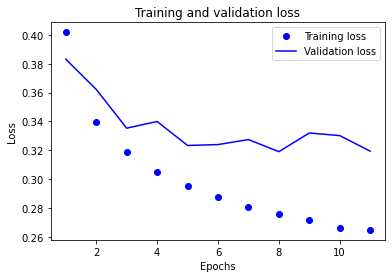

In [47]:
print("CNN 1 Accuracy result : ", model.evaluate(X_test, y_test, verbose=2))

show_plot(history_cnn1.history)

In [48]:
## 모델 저장
model.save(BASIC_PATH + 'final/CNN_model_hyper_x1.h5')

### [5-3] BiLSTM

In [49]:
bilstm = Sequential()
bilstm.add(Embedding(vocab_size, word_vector_dim))
bilstm.add(Bidirectional(LSTM(128)))
bilstm.add(Dense(1, activation='sigmoid'))

In [50]:
es3 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc3 = ModelCheckpoint(BASIC_PATH + 'final/BiLSTM_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

bilstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
history_bilstm = bilstm.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=2,
                    callbacks = [es3, mc3])

Train on 118857 samples, validate on 29715 samples
Epoch 1/20
118857/118857 - 25s - loss: 0.3589 - accuracy: 0.8417 - val_loss: 0.3430 - val_accuracy: 0.8519
Epoch 2/20
118857/118857 - 25s - loss: 0.3150 - accuracy: 0.8655 - val_loss: 0.3241 - val_accuracy: 0.8641
Epoch 3/20
118857/118857 - 25s - loss: 0.2903 - accuracy: 0.8782 - val_loss: 0.3280 - val_accuracy: 0.8567
Epoch 4/20
118857/118857 - 25s - loss: 0.2706 - accuracy: 0.8883 - val_loss: 0.3122 - val_accuracy: 0.8682
Epoch 5/20
118857/118857 - 25s - loss: 0.2539 - accuracy: 0.8962 - val_loss: 0.3328 - val_accuracy: 0.8580
Epoch 6/20
118857/118857 - 25s - loss: 0.2382 - accuracy: 0.9039 - val_loss: 0.3269 - val_accuracy: 0.8648
Epoch 7/20
118857/118857 - 25s - loss: 0.2236 - accuracy: 0.9117 - val_loss: 0.3306 - val_accuracy: 0.8605
Epoch 00007: early stopping


49575/49575 - 5s - loss: 0.3333 - accuracy: 0.8588
BiLSTM Accuracy result :  [0.3332691738512921, 0.85884017]


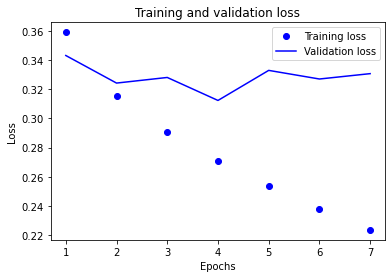

In [53]:
print("BiLSTM Accuracy result : ", bilstm.evaluate(X_test, y_test, verbose=2))

show_plot(history_bilstm.history)

In [59]:
## 모델 저장
bilstm.save(BASIC_PATH + 'final/BiLSTM_model.h5')

### [5-4] GRU

In [55]:
gru = Sequential()
gru.add(Embedding(vocab_size, word_vector_dim))
gru.add(GRU(128))
gru.add(Dense(1, activation='sigmoid'))

In [64]:
es4 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc4 = ModelCheckpoint(BASIC_PATH + 'final/GRU_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

gru.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [65]:
history_gru = gru.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=2,
                    callbacks = [es4, mc4])

Train on 118857 samples, validate on 29715 samples
Epoch 1/20
118857/118857 - 21s - loss: 0.2267 - accuracy: 0.9094 - val_loss: 0.3270 - val_accuracy: 0.8624
Epoch 2/20
118857/118857 - 20s - loss: 0.2099 - accuracy: 0.9178 - val_loss: 0.3387 - val_accuracy: 0.8623
Epoch 3/20
118857/118857 - 20s - loss: 0.1919 - accuracy: 0.9260 - val_loss: 0.3532 - val_accuracy: 0.8564
Epoch 4/20
118857/118857 - 20s - loss: 0.1742 - accuracy: 0.9330 - val_loss: 0.3797 - val_accuracy: 0.8536
Epoch 5/20
118857/118857 - 20s - loss: 0.1567 - accuracy: 0.9405 - val_loss: 0.4075 - val_accuracy: 0.8429
Epoch 00005: early stopping


49575/49575 - 3s - loss: 0.3990 - accuracy: 0.8452
GRU Accuracy result :  [0.3989836451554022, 0.8452446]


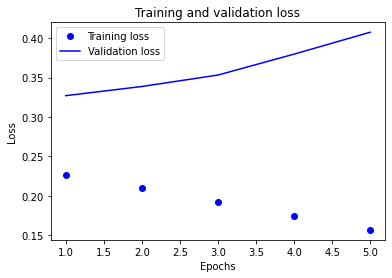

In [66]:
print("GRU Accuracy result : ", gru.evaluate(X_test, y_test, verbose=2))

show_plot(history_gru.history)

In [67]:
## 모델 저장
gru.save(BASIC_PATH + 'final/GRU_model.h5')

### [5-5] CNN-LSTM

1. (100, 5), (64, 3) => 85.64%
2. (128, 3), (128, 4) =>

In [26]:
cnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 100)      2074400     input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 50, 100)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 47, 512)      205312      dropout[0][0]                    
______________________________________________________________________________________________

In [27]:
print(best_hyperparameters['dropout1'])
print(best_hyperparameters['conv_blocks'])
print(best_hyperparameters['filters_1'])
print(best_hyperparameters['filters_2'])
print(best_hyperparameters['kernel_size_1'])
print(best_hyperparameters['kernel_size_2'])
print(best_hyperparameters['pooling_1'])
print(best_hyperparameters['pooling_2'])
print(best_hyperparameters['dropout2'])
print(best_hyperparameters['hidden_size'])
print(best_hyperparameters['learning_rate'])
print(best_hyperparameters['optimizer_'])

0.30000000000000004
2
64
128
3
4
max
global
0.2
512
0.0006990081689951592
rmsprop


In [31]:
model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, word_vector_dim, input_length = max_len)(model_input)
z = Dropout(0.3)(z)
z = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,))(z)
conv_blocks = []

conv = Conv1D(filters = 64, kernel_size = 3, padding = "valid", activation = "relu", strides = 1)(z)
conv = MaxPooling1D()(conv)
conv = Flatten()(conv)
conv_blocks.append(conv)
conv = Conv1D(filters = 128, kernel_size = 4, padding = "valid", activation = "relu", strides = 1)(z)
conv = GlobalMaxPooling1D()(conv)
conv = Flatten()(conv)
conv_blocks.append(conv)
    
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(0.2)(z)
z = Dense(128, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

cnn_lstm = Model(model_input, model_output)

In [32]:
es5 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc5 = ModelCheckpoint(BASIC_PATH + 'final/CNN_LSTM_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

cnn_lstm.compile(optimizer=tf.keras.optimizers.RMSprop(best_hyperparameters['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
history_cnn_lstm = cnn_lstm.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=2,
                    callbacks = [es5, mc5])

Train on 118857 samples, validate on 29715 samples
Epoch 1/20
118857/118857 - 395s - loss: 0.3967 - accuracy: 0.8175 - val_loss: 0.3453 - val_accuracy: 0.8512
Epoch 2/20
118857/118857 - 374s - loss: 0.3345 - accuracy: 0.8563 - val_loss: 0.3502 - val_accuracy: 0.8450
Epoch 3/20
118857/118857 - 147s - loss: 0.3126 - accuracy: 0.8675 - val_loss: 0.3185 - val_accuracy: 0.8642
Epoch 4/20
118857/118857 - 147s - loss: 0.2985 - accuracy: 0.8746 - val_loss: 0.3240 - val_accuracy: 0.8613
Epoch 5/20
118857/118857 - 146s - loss: 0.2881 - accuracy: 0.8812 - val_loss: 0.3144 - val_accuracy: 0.8696
Epoch 6/20
118857/118857 - 146s - loss: 0.2775 - accuracy: 0.8864 - val_loss: 0.3095 - val_accuracy: 0.8678
Epoch 7/20
118857/118857 - 149s - loss: 0.2716 - accuracy: 0.8895 - val_loss: 0.3102 - val_accuracy: 0.8687
Epoch 8/20
118857/118857 - 146s - loss: 0.2642 - accuracy: 0.8931 - val_loss: 0.3112 - val_accuracy: 0.8697
Epoch 9/20
118857/118857 - 146s - loss: 0.2586 - accuracy: 0.8970 - val_loss: 0.3767 

49575/49575 - 26s - loss: 0.3544 - accuracy: 0.8495
CNN-LSTM Accuracy result :  [0.35441381320890847, 0.8495411]


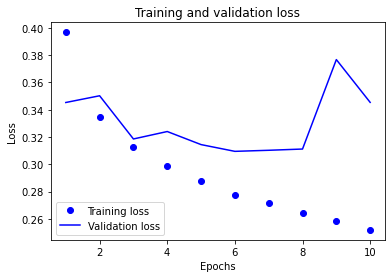

In [34]:
print("CNN-LSTM Accuracy result : ", cnn_lstm.evaluate(X_test, y_test, verbose=2))

show_plot(history_cnn_lstm.history)

In [35]:
## 모델 저장
cnn_lstm.save(BASIC_PATH + 'final/CNN_LSTM_model.h5')

#### hyper parametes tuning x

In [82]:
cnn_lstm = Sequential()

# Layer 1: Embedding layer
cnn_lstm.add(Embedding(vocab_size, word_vector_dim, input_length=max_len))

# Layer 2: Bi-Directional LSTM
cnn_lstm.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,)))

# Layer 3: 1D Convolutional Layer
cnn_lstm.add(Conv1D(filters = 128, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'))
cnn_lstm.add(Conv1D(filters = 128, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu'))
cnn_lstm.add(GlobalMaxPooling1D())

# Layer 4: Output Layer
cnn_lstm.add(Dense(1, activation='sigmoid'))

In [83]:
es5 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc5 = ModelCheckpoint(BASIC_PATH + 'final/CNN_LSTM_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

cnn_lstm.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [84]:
history_cnn_lstm = cnn_lstm.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    verbose=2,
                    callbacks = [es5, mc5])

Train on 118857 samples, validate on 29715 samples
Epoch 1/20
118857/118857 - 175s - loss: 0.3806 - accuracy: 0.8284 - val_loss: 0.3327 - val_accuracy: 0.8548
Epoch 2/20
118857/118857 - 171s - loss: 0.3148 - accuracy: 0.8656 - val_loss: 0.3170 - val_accuracy: 0.8654
Epoch 3/20
118857/118857 - 171s - loss: 0.2892 - accuracy: 0.8803 - val_loss: 0.3122 - val_accuracy: 0.8692
Epoch 4/20
118857/118857 - 171s - loss: 0.2694 - accuracy: 0.8900 - val_loss: 0.3476 - val_accuracy: 0.8527
Epoch 5/20
118857/118857 - 172s - loss: 0.2535 - accuracy: 0.8989 - val_loss: 0.3443 - val_accuracy: 0.8559
Epoch 6/20
118857/118857 - 171s - loss: 0.2407 - accuracy: 0.9054 - val_loss: 0.3343 - val_accuracy: 0.8590
Epoch 7/20
118857/118857 - 171s - loss: 0.2291 - accuracy: 0.9104 - val_loss: 0.3346 - val_accuracy: 0.8658
Epoch 00007: early stopping


49575/49575 - 28s - loss: 0.3384 - accuracy: 0.8630
CNN-LSTM Accuracy result :  [0.3384316702557524, 0.8629551]


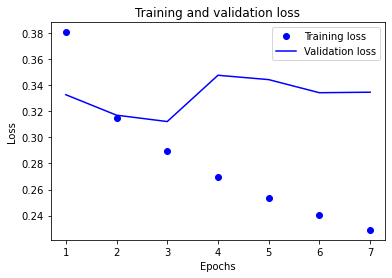

In [85]:
print("CNN-LSTM Accuracy result : ", cnn_lstm.evaluate(X_test, y_test, verbose=2))

show_plot(history_cnn_lstm.history)

In [86]:
## 모델 저장
cnn_lstm.save(BASIC_PATH + 'final/CNN_LSTM_model.h5')